In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import os
import re
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string
from collections import defaultdict
from nltk.stem.porter import PorterStemmer
import pickle
from IPython.display import clear_output
from gensim import corpora, models
from gensim.models import Phrases, Word2Vec
from gensim.models.phrases import Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Read in and combine dfs of full dataset
funded_projects = pd.DataFrame()
for root, dirs, files in os.walk("data/completed_full_csv_parts/", topdown=True):
    for file in files:
        df = pd.read_csv(os.path.join(root, file))
        funded_projects = funded_projects.append(df)

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,5,11,12,15,17,19,23,24,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,12,19,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,11,12,15,19,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (

In [3]:
# keep just R01s
funded_R01_projects = funded_projects[funded_projects.grant_num.str.contains("R01")]

In [4]:
years = funded_R01_projects.FY.astype(int).sort_values().unique().tolist()

In [5]:
# split by year, make list of dfs
dfs = list()
for year in years:
    df = funded_R01_projects[funded_R01_projects["FY"] == year]
    dfs.append(df)

In [6]:
strange_symbols = ["\xa0", "-\xad", "/"]

In [7]:
things_to_replace = ["unreadable",
                     "[unreadable]",
                     "DESCRIPTION",
                     "Application not provided", 
                     "Description Provided by Applicant",
                     "(Adapted from applicant's abstract)",
                     "(provided by applicant)",
                     "(Verbatim from applicants abstract)",
                     "Purpose",
                     "(Adapted from the Applicant's )",
                     " N A",
                     "(provided by investigator)",
                     "(From the Applicant's )",
                     "DESCRIPTION (provided by applicant)",
                     "ABSTRACT",
                     "Abstract",
                     "Project Summary/Abstract",
                     "PROJECT SUMMARY",
                     "Background:",
                     "Project Summary / Abstract",
                     "Project Summary",
                     "PROJECT SUMMARY/ABSTRACT",
                     "Summary/Abstract",
                     "||",
                     "Summary",
                     "PROJECT SUMMARY / ABSTRACT"]

In [8]:
punct = [p for p in string.punctuation]+["``", "''"]

In [9]:
stop_words = stopwords.words("english")

In [10]:
ps = PorterStemmer()

In [11]:
def average_token_length(doc):
    """calculate the average length of each token in a document"""
    
    #make list of lengths of each token
    lengths = list()
    for word in doc:
        l = len(word)
        lengths.append(l)
        
    #calculate mean
    if len(lengths) > 0:
        mean = np.mean(lengths)
    else:
        mean = 0
    
    return(mean)

In [12]:
def find_bad_abstracts(abs_list):
    
    abstracts = list()
    for abst in abs_list:
        abstract = word_tokenize(abst)
        abstracts.append(abstract)
        
    means = list()
    for a in abstracts:
        means.append(average_token_length(a))
        
    good_abstracts = []    
    for m, a in zip(means, abstracts):
        if m < 7:
            good_abstracts.append(a)
        
    return(good_abstracts)

In [13]:
def clean_abstract_text(df):
    
    
    abs_list = df.ABSTRACT_TEXT.tolist()
    
    for symb in strange_symbols:
        abs_list = [abstract.replace(symb, ' ') for abstract in abs_list]
        
    for phrase in things_to_replace:
        abs_list = [abstract.replace(phrase, '') for abstract in abs_list]
        
    abs_list = [re.sub(" +", " ", abstract) for abstract in abs_list]
    
    good_abstracts = find_bad_abstracts(abs_list)
    
    for ind, a in enumerate(good_abstracts):
        words = [word.lower() for word in a if word not in punct]
        words = [word for word in words if word not in stop_words]
        words = [word for word in words if not word.isdigit()]
        words = [ps.stem(word) for word in words]
        good_abstracts[ind] = words
        
    return(good_abstracts)

In [14]:
funding_summary = pd.read_html("data/RCDCFundingSummary071218.xls", header = 0)[0]

In [15]:
research_areas = funding_summary["Research/Disease Areas(Dollars in millions and rounded)"].tolist()

In [16]:
research_areas_cleaned = [re.sub(" \d+/", "", area) for area in research_areas]

In [17]:
def add_abstract_categories(df, col, new_col):
    
    """Search terms in selected col and return values that are in NIH list of research categories.
    Add list to new column. col and new_col should be strings"""
    
    column_list = df[col].tolist()
    
    terms_list = []
    for l in column_list:
        if type(l) != float:
            terms = l.split(";")
            terms_list.append(terms)
        else:
            terms_list.append([])
    
    categories = []
    for terms in terms_list:
        category = list(set(research_areas_cleaned) & set(terms))
        categories.append(category)
        
    df[new_col] = categories

In [18]:
cols = ["PROJECT_TERMS", "NIH_SPENDING_CATS"]
new_cols = ["topics_proj_terms", "topics_spending_cats"]

for c1, c2 in zip(cols, new_cols):
    add_abstract_categories(funded_R01_projects, c1, c2)

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
funded_R01_projects.columns

Index(['APPLICATION_ID', 'ARRA_FUNDED', 'AWARD_NOTICE_DATE', 'BUDGET_END',
       'BUDGET_START', 'CFDA_CODE', 'CORE_PROJECT_NUM', 'DIRECT_COST_AMT',
       'ED_INST_TYPE', 'FOA_NUMBER', 'FULL_PROJECT_NUM', 'FUNDING_ICs',
       'FUNDING_MECHANISM', 'FY', 'INDIRECT_COST_AMT', 'NIH_SPENDING_CATS',
       'ORG_CITY', 'ORG_DEPT', 'ORG_DISTRICT', 'ORG_DUNS', 'ORG_FIPS',
       'ORG_NAME', 'ORG_STATE', 'ORG_ZIPCODE', 'PHR', 'PI_IDS',
       'PROGRAM_OFFICER_NAME', 'PROJECT_END', 'PROJECT_START', 'PROJECT_TERMS',
       'PROJECT_TITLE', 'STUDY_SECTION', 'SUBPROJECT_ID', 'SUFFIX',
       'TOTAL_COST', 'TOTAL_COST_SUB_PROJECT', 'ABSTRACT_TEXT', 'grant_num',
       'topics_proj_terms', 'topics_spending_cats'],
      dtype='object')

In [20]:
topics_total = []
for r in funded_R01_projects.iterrows():
    row = r[1]
    total_topics = list(set(row.topics_proj_terms+row.topics_spending_cats))
    topics_total.append(total_topics)

In [21]:
funded_R01_projects["topics_total"] = topics_total

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
funded_R01_projects.columns

Index(['APPLICATION_ID', 'ARRA_FUNDED', 'AWARD_NOTICE_DATE', 'BUDGET_END',
       'BUDGET_START', 'CFDA_CODE', 'CORE_PROJECT_NUM', 'DIRECT_COST_AMT',
       'ED_INST_TYPE', 'FOA_NUMBER', 'FULL_PROJECT_NUM', 'FUNDING_ICs',
       'FUNDING_MECHANISM', 'FY', 'INDIRECT_COST_AMT', 'NIH_SPENDING_CATS',
       'ORG_CITY', 'ORG_DEPT', 'ORG_DISTRICT', 'ORG_DUNS', 'ORG_FIPS',
       'ORG_NAME', 'ORG_STATE', 'ORG_ZIPCODE', 'PHR', 'PI_IDS',
       'PROGRAM_OFFICER_NAME', 'PROJECT_END', 'PROJECT_START', 'PROJECT_TERMS',
       'PROJECT_TITLE', 'STUDY_SECTION', 'SUBPROJECT_ID', 'SUFFIX',
       'TOTAL_COST', 'TOTAL_COST_SUB_PROJECT', 'ABSTRACT_TEXT', 'grant_num',
       'topics_proj_terms', 'topics_spending_cats', 'topics_total'],
      dtype='object')

In [23]:
# Check to make sure there are some grants that don't have topics associated
funded_R01_projects.head()

,APPLICATION_ID,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_END,BUDGET_START,CFDA_CODE,CORE_PROJECT_NUM,DIRECT_COST_AMT,ED_INST_TYPE,FOA_NUMBER,...,STUDY_SECTION,SUBPROJECT_ID,SUFFIX,TOTAL_COST,TOTAL_COST_SUB_PROJECT,ABSTRACT_TEXT,grant_num,topics_proj_terms,topics_spending_cats,topics_total
2185,7499670,NaN,2008-09-12T00:00:00,08/31/2009,09/01/2008,389.0,U24RR018107,NaN,SCHOOLS OF MEDICINE,NaN,...,RIRG,NaN,NaN,741430.0,NaN,[unreadable] DESCRIPTION (provided by applic...,U24RR018107,[],[],[]
2186,7495989,NaN,2008-09-16T00:00:00,06/30/2009,09/01/2008,389.0,U24RR018108,NaN,UNIVERSITY-WIDE,NaN,...,RIRG,NaN,NaN,1811959.0,NaN,[unreadable] DESCRIPTION (provided by applic...,U24RR018108,[],[],[]
2187,7502303,NaN,2008-09-01T00:00:00,06/30/2009,09/01/2008,389.0,U24RR018109,NaN,PRIMATE CENTERS,NaN,...,RIRG,NaN,A1,1431792.0,NaN,[unreadable] DESCRIPTION (provided by applic...,U24RR018109,[],[],[]
2188,7501548,NaN,2008-06-30T00:00:00,06/30/2009,07/01/2008,389.0,U24RR018111,NaN,PRIMATE CENTERS,NaN,...,RIRG,NaN,A1,1908805.0,NaN,[unreadable] DESCRIPTION (provided by applic...,U24RR018111,[],[],[]
2189,7439671,NaN,2008-08-16T00:00:00,05/31/2009,08/18/2008,389.0,U24RR018144,NaN,PRIMATE CENTERS,NaN,...,RIRG,NaN,NaN,2067808.0,NaN,[unreadable] DESCRIPTION (provided by applic...,U24RR018144,[],[],[]


In [24]:
abstract_topic = funded_R01_projects[["FY", "ABSTRACT_TEXT", "topics_total"]]
abstract_topic.reset_index(drop = True, inplace = True)
abstract_topic.drop_duplicates('ABSTRACT_TEXT', inplace = True)

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
len(abstract_topic)

272108

In [26]:
inds_per_cat = []
for c in research_areas_cleaned:
    inds = []
    for ind, l in enumerate(abstract_topic.topics_total):
        if c in l:
            inds.append(ind)
    inds_per_cat.append(inds)

In [27]:
len(inds_per_cat)

285

In [28]:
# len(inds_per_cat[0])
num_abs_per_topic = [len(cat) for cat in inds_per_cat]

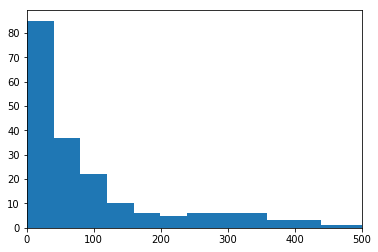

In [29]:
plt.hist(num_abs_per_topic, bins = 600)
plt.xlim(xmin = 0, xmax=500);

In [30]:
cat_dfs_list = [abstract_topic.iloc[cat] for cat in inds_per_cat]

In [31]:
len(cat_dfs_list)

285

In [32]:
topics_with_abstracts = []
for cat, df in zip(research_areas_cleaned, cat_dfs_list):
    if len(df) > 100: # exclude any category that has fewer than 100 associated abstracts
        topics_with_abstracts.append(cat)
        #print(len(df))

In [33]:
len(topics_with_abstracts)

153

In [34]:
topics_with_abstracts[0]

'Acquired Cognitive Impairment'

In [35]:
# Set bottom threshold of 100 abs per cat
bottom_thresh = [cat for cat in inds_per_cat if len(cat)>100]

In [36]:
len(bottom_thresh)

153

In [37]:
len(topics_with_abstracts[0][1])

1

In [38]:
# cleaned_abstracts = []
# l = len(topics_with_abstracts)
# for ind, cat in enumerate(topics_with_abstracts):
#     cleaned_abstracts.append(clean_abstract_text(cat[1]))
#     clear_output()
#     print("finished {} out of {}".format(ind+1, l))

In [39]:
abstract_topic_2008 = abstract_topic[abstract_topic.FY == 2008]

In [40]:
[cat for cat in research_areas_cleaned if "eurosci" in cat]

['Neurosciences']

In [41]:
neurosciences = []
not_neurosciences = []
for ind, l in enumerate(abstract_topic_2008.topics_total):
    if "Neurosciences" in l:
        neurosciences.append(ind)
    else:
        not_neurosciences.append(ind)

In [42]:
neuro_2008_df = abstract_topic_2008.iloc[neurosciences]
not_neuro_2008_df = abstract_topic_2008.iloc[not_neurosciences]

In [43]:
neuro_abs_clean = clean_abstract_text(neuro_2008_df)
not_neuro_abs_clean = clean_abstract_text(not_neuro_2008_df)

In [44]:
neuro_abs_clean_unlist = list(set([" ".join(a) for a in neuro_abs_clean]))
not_neuro_abs_clean_unlist = list(set([" ".join(a) for a in not_neuro_abs_clean]))

In [45]:
neuro_df_lr = pd.DataFrame(neuro_abs_clean_unlist, columns = ["sentences"])

not_neuro_df_lr = pd.DataFrame(not_neuro_abs_clean_unlist, columns = ["sentences"])

# new column assigning if sentence is about category or not. 1 = yes, 0 = no

neuro_df_lr["in_category"] = 1

not_neuro_df_lr["in_category"] = 0

neuro_2008_lr = pd.concat([neuro_df_lr, not_neuro_df_lr])

In [46]:
neuro_2008_lr

,sentences,in_category
0,human vision start photoreceptor collect respo...,1
1,cognit impair debilit outcom alzheim 's diseas...,1
2,schizophrenia common sever mental disord lead ...,1
3,provid applic posttraumat stress disord ptsd c...,1
4,aim propos studi development regul synapt plas...,1
5,methamphetamin depend associ deficit marker fr...,1
6,central featur theori regard cerebellar functi...,1
7,character drosophila antenn lobe describ propo...,1
8,stroke lead caus long-term disabl unit state a...,1
9,hiv enter cn acut infect howev viru replic app...,1


In [47]:
def train_lr_model(df, ngram_range = (1, 4), cm = True):
    """Prepare text with TfidfVectorizer, 
    Select top features based on chi2, 
    and fit model using LogisticRegressionCV.
    Return score and predictions"""
    
    # initialize TfidfVectorizer, specifying certain hyperparameters
    tfidf = TfidfVectorizer(sublinear_tf = True, # use log to scale tf
                           norm = "l2", # norm method
                           ngram_range = ngram_range, # n-gram range to test (default is unigram to fourgram)
                           stop_words = "english") # language to use when removing stopwords
    
    # select input variables from dataframe 
    X = df.sentences 
    y = df.in_category
    
    # fit and transform text column
    X_tfidf = tfidf.fit_transform(X)
    
    # split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

    # select features to use for model
    ch2 = SelectKBest(chi2, k=1000) # select top 1000 features based on chi2
    
    # fit and transform training and test data using previously selected features
    X_train_chi2_selected = ch2.fit_transform(X_train, y_train)
    X_test_chi2_selected = ch2.transform(X_test)
    
    # initialize logistic regression
    lr = LogisticRegressionCV(cv = 5, penalty = "l2")
    
    # fit lr model to training data
    lr_model = lr.fit(X_train_chi2_selected, y_train)
    
    # use model to predict values for test data
    y_pred = lr_model.predict(X_test_chi2_selected)
    
    # score the model
    score = lr.score(X_test_chi2_selected, y_test)
    
    print("Score: ", score, "\n")
    
    if cm == True:
        # Count values for confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test.tolist(), y_pred).ravel()
        
        data = {'no': [tn, fp], 'yes': [fn, tp]}
        cm = pd.DataFrame.from_dict(data, orient='index',
                                    columns=["no", "yes"])
        print("Confusion Matrix:\n", cm, '\n', '_' * 30)
       
    return(tfidf, ch2, lr_model)

In [48]:
neuro_2008_lr_model = train_lr_model(neuro_2008_lr)

Score:  0.955044955044955 

Confusion Matrix:
        no   yes
no   5881   117
yes   243  1767 
 ______________________________


In [50]:
abstracts_with_topics = abstract_topic.iloc[[ind for ind, a in enumerate(abstract_topic.topics_total) if len(a) > 0]]

In [51]:
len(abstracts_with_topics)

225038

In [52]:
abstracts_with_topics_unique = abstracts_with_topics.drop_duplicates('ABSTRACT_TEXT')

In [53]:
len(abstracts_with_topics_unique)

129573

In [54]:
topics_with_abstracts_2 = list(set([item for sublist in abstracts_with_topics_unique.topics_total.tolist() for item in sublist]))

In [56]:
len(topics_with_abstracts_2)

248

In [42]:
# This noise takes WAY too long to run, figure out new method

# models = []


# for area in topics_with_abstracts:
#     pos = []
#     neg = []
#     for ind, l in enumerate(abstracts_with_topics_unique.topics_total):
#         if area in l:
#             pos.append(ind)
#         else:
#             neg.append(ind)
            
            
#     pos_df = abstracts_with_topics.iloc[pos]
#     neg_df = abstracts_with_topics.iloc[neg]
    
    
#     pos_abs_clean = clean_abstract_text(pos_df)
#     neg_abs_clean = clean_abstract_text(neg_df)
    
    
#     pos_abs_clean_unlist = list(set([" ".join(a) for a in pos_abs_clean]))
#     neg_abs_clean_unlist = list(set([" ".join(a) for a in neg_abs_clean]))
    
    
#     pos_df_lr = pd.DataFrame(pos_abs_clean_unlist, columns = ["sentences"])

#     neg_df_lr = pd.DataFrame(neg_abs_clean_unlist, columns = ["sentences"])
    
#     pos_df_lr["in_category"] = 1
    
#     neg_df_lr["in_category"] = 0
    
#     df_lr = pd.concat([pos_df_lr, neg_df_lr])
    
    
#     model = train_lr_model(df_lr)
    
#     models.append(model)

Score:  0.9998598556513209 

Confusion Matrix:
         no  yes
no   28538    0
yes      4    0
Score:  0.9998598507410392 

Confusion Matrix:
         no  yes
no   28537    0
yes      4    0
Score:  0.9988797087242683 

Confusion Matrix:
         no  yes
no   28532    0
yes     32    0
Score:  0.985105272315991 

Confusion Matrix:
         no  yes
no   28306   19
yes    409    1
Score:  0.9953210656796676 

Confusion Matrix:
         no  yes
no   28505    0
yes    134    0
Score:  0.9998598507410392 

Confusion Matrix:
         no  yes
no   28537    0
yes      4    0
Score:  0.9972029927977064 

Confusion Matrix:
         no  yes
no   28522    0
yes     80    0
Score:  0.9927801611384326 

Confusion Matrix:
         no  yes
no   28464   21
yes    186    0
Score:  0.9968178480260167 

Confusion Matrix:
         no  yes
no   28506    0
yes     91    0
Score:  0.997970821817164 

Confusion Matrix:
         no  yes
no   28525    0
yes     58    0
Score:  0.9811902452542608 

Confusion Mat

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Score:  1.0 



ValueError: not enough values to unpack (expected 4, got 1)

### Above script takes way too long to run, to go through >200 categories is insane and will take too long with time left. Instead come up with shorter method:
- Make min and max number of documents for training set
    - Histogram of number of abstracts showed that many categores have fewer than 100 abstracts associated, do not include these
    - Select only 1000 documents for training set: <= 500 positive examples and remaining negative examples

In [57]:
topics_with_abstracts[0]

('Acquired Cognitive Impairment',
             FY                                      ABSTRACT_TEXT  \
 191447  2016.0  DESCRIPTION (provided by applicant): This gran...   
 191450  2016.0  DESCRIPTION (provided by applicant): This revi...   
 191476  2016.0  For the past 15 years, we have studied cogniti...   
 191521  2016.0  microRNA (miRNA) signaling in Alzheimer's dise...   
 191525  2016.0  ?     DESCRIPTION (provided by applicant): Bac...   
 191546  2016.0  DESCRIPTION (provided by applicant): Abnormal ...   
 191562  2016.0  ?     DESCRIPTION (provided by applicant):  Li...   
 191620  2016.0  DESCRIPTION (provided by applicant): By 2050 o...   
 191671  2016.0  DESCRIPTION (provided by applicant): Despite t...   
 191687  2016.0  DESCRIPTION:  A recent Institute of Medicine r...   
 191702  2016.0  DESCRIPTION (provided by applicant): APOE geno...   
 191703  2016.0  DESCRIPTION (provided by applicant):     Combi...   
 191746  2016.0  DESCRIPTION (provided by applicant):  D

In [148]:
models = []


for area in topics_with_abstracts:
    print(area)
    pos = []
    neg = []
    for ind, l in enumerate(abstract_topic.topics_total):
        if area in l:
            pos.append(ind)
        else:
            neg.append(ind)
            
    if len(pos) > 500:
        pos_df = abstract_topic.iloc[np.random.choice(pos, 500)]
    else:
        pos_df = abstract_topic.iloc[pos]
    
    neg_df = abstract_topic.iloc[np.random.choice(neg, (1000-len(pos_df)))]
    
    
    pos_df_clean = clean_abstract_text(pos_df)
    neg_df_clean = clean_abstract_text(neg_df)
    
    
    pos_df_clean_unlist = [" ".join(a) for a in pos_df_clean]
    neg_df_clean_unlist = [" ".join(a) for a in neg_df_clean]
    
    
    pos_df_lr = pd.DataFrame(pos_df_clean_unlist, columns = ["sentences"])

    neg_df_lr = pd.DataFrame(neg_df_clean_unlist, columns = ["sentences"])
    
    pos_df_lr["in_category"] = 1
    
    neg_df_lr["in_category"] = 0
    
    df_lr = pd.concat([pos_df_lr, neg_df_lr])
    
    
    model = train_lr_model(df_lr)
    
    models.append(model)

Acquired Cognitive Impairment
Score:  0.9363636363636364 

Confusion Matrix:
       no  yes
no   190    5
yes   16  119 
 ______________________________
Acute Respiratory Distress Syndrome
Score:  0.9818181818181818 

Confusion Matrix:
       no  yes
no   162    3
yes    3  162 
 ______________________________
Adolescent Sexual Activity
Score:  0.9545454545454546 

Confusion Matrix:
       no  yes
no   273    3
yes   12   42 
 ______________________________
Aging
Score:  0.8424242424242424 

Confusion Matrix:
       no  yes
no   143   22
yes   30  135 
 ______________________________
Alcoholism, Alcohol Use and Health
Score:  0.9272727272727272 

Confusion Matrix:
       no  yes
no   278    3
yes   21   28 
 ______________________________
ALS
Score:  0.9606060606060606 

Confusion Matrix:
       no  yes
no   208    3
yes   10  109 
 ______________________________
Alzheimer's Disease
Score:  0.8878787878787879 

Confusion Matrix:
       no  yes
no   157    8
yes   29  136 
 ____________

Score:  0.9272727272727272 

Confusion Matrix:
       no  yes
no   269    6
yes   18   37 
 ______________________________
Duchenne/ Becker Muscular Dystrophy
Score:  0.9878787878787879 

Confusion Matrix:
       no  yes
no   304    0
yes    4   22 
 ______________________________
Dystonia
Score:  0.9696969696969697 

Confusion Matrix:
       no  yes
no   296    0
yes   10   24 
 ______________________________
Eating Disorders
Score:  0.9757575757575757 

Confusion Matrix:
       no  yes
no   281    1
yes    7   41 
 ______________________________
Emerging Infectious Diseases
Score:  0.8757575757575757 

Confusion Matrix:
       no  yes
no   142   23
yes   18  147 
 ______________________________
Emphysema
Score:  0.9757575757575757 

Confusion Matrix:
       no  yes
no   290    0
yes    8   32 
 ______________________________
Endocrine Disruptors
Score:  0.9848484848484849 

Confusion Matrix:
       no  yes
no   296    0
yes    5   29 
 ______________________________
Epilepsy
Score:  

Score:  0.8545454545454545 

Confusion Matrix:
       no  yes
no   151   14
yes   34  131 
 ______________________________
Neurosciences
Score:  0.7393939393939394 

Confusion Matrix:
       no  yes
no   127   38
yes   48  117 
 ______________________________
Nutrition
Score:  0.8878787878787879 

Confusion Matrix:
       no  yes
no   155   10
yes   27  138 
 ______________________________
Obesity
Score:  0.8909090909090909 

Confusion Matrix:
       no  yes
no   153   12
yes   24  141 
 ______________________________
Organ Transplantation
Score:  0.9333333333333333 

Confusion Matrix:
       no  yes
no   153   12
yes   10  155 
 ______________________________
Orphan Drug
Score:  0.8363636363636363 

Confusion Matrix:
       no  yes
no   142   23
yes   31  134 
 ______________________________
Osteoarthritis
Score:  0.9666666666666667 

Confusion Matrix:
       no  yes
no   290    0
yes   11   29 
 ______________________________
Osteoporosis
Score:  0.9454545454545454 

Confusion Matrix

Score:  0.9545454545454546 

Confusion Matrix:
       no  yes
no   159    6
yes    9  156 
 ______________________________
Violence Against Women
Score:  0.9878787878787879 

Confusion Matrix:
       no  yes
no   288    0
yes    4   38 
 ______________________________
Violence Research
Score:  0.9666666666666667 

Confusion Matrix:
       no  yes
no   156    9
yes    2  163 
 ______________________________
Women's Health
Score:  0.9272727272727272 

Confusion Matrix:
       no  yes
no   209    6
yes   18   97 
 ______________________________
Youth Violence
Score:  0.9575757575757575 

Confusion Matrix:
       no  yes
no   205    7
yes    7  111 
 ______________________________


In [84]:
len(models)

180

In [83]:
from sklearn.externals import joblib

In [149]:
names = [topic.replace("/", "_") for topic in topics_with_abstracts]

In [154]:
models[0][2]

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [166]:
for name, model in zip(names, models):
    print(name)
    tfidf_model = model[0]
    ch2_model = model[1]
    lr_model = model[2]
    joblib.dump(tfidf_model, "data/models/{}.tfidf.pkl".format(name))
    joblib.dump(ch2_model, "data/models/{}_ch2.pkl".format(name))
    joblib.dump(lr_model, "data/models/{}_lr.pkl".format(name))

Acquired Cognitive Impairment
Acute Respiratory Distress Syndrome
Adolescent Sexual Activity
Aging
Alcoholism, Alcohol Use and Health
ALS
Alzheimer's Disease
Anorexia
Anthrax
Antimicrobial Resistance
Anxiety Disorders
Aphasia
Arthritis
Assistive Technology
Asthma
Ataxia Telangiectasia
Atherosclerosis
Attention Deficit Disorder (ADD)
Autism
Autoimmune Disease
Back Pain
Basic Behavioral and Social Science
Behavioral and Social Science
Biodefense
Bioengineering
Biotechnology
Bipolar Disorder
Brain Cancer
Brain Disorders
Breast Cancer
Cachexia
Cancer
Cardiovascular
Cerebral Palsy
Cervical Cancer
Charcot-Marie-Tooth Disease
Child Abuse and Neglect Research
Childhood Leukemia
Chronic Liver Disease and Cirrhosis
Chronic Obstructive Pulmonary Disease
Climate-Related Exposures and Conditions
Clinical Research
Colo-Rectal Cancer
Comparative Effectiveness Research
Complementary and Alternative Medicine
Congenital Structural Anomalies
Contraception_Reproduction
Cooley's Anemia
Cost Effectiveness R

In [ ]:
# for loading model back into environment
# joblib.load('filename.pkl')

In [93]:
df_test = abstract_topic.head(100)

In [111]:
df_test_clean = clean_abstract_text(df_test)

df_test_clean_unlist = [" ".join(a) for a in df_test_clean]

df_test_lr = pd.DataFrame(df_test_clean_unlist, columns = ["sentences"])

In [114]:
df_test_lr.head()

,sentences
0,project need indian rhesu macaqu aids-rel rese...
1,object propos maintain close specif pathogen-f...
2,central object project breed rhesu macaqu spec...
3,past five year tulan nation primat research ce...
4,goal propos expand product genet character rhe...


In [106]:
pos = []
neg = []
for ind, l in enumerate(abstract_topic.topics_total):
    if topics_with_abstracts[0] in l:
        pos.append(ind)
    else:
        neg.append(ind)
        
if len(pos) > 500:
    pos_df = abstract_topic.iloc[np.random.choice(pos, 500)]
else:
    pos_df = abstract_topic.iloc[pos]

neg_df = abstract_topic.iloc[np.random.choice(neg, (1000-len(pos_df)))]


pos_df_clean = clean_abstract_text(pos_df)
neg_df_clean = clean_abstract_text(neg_df)


pos_df_clean_unlist = [" ".join(a) for a in pos_df_clean]
neg_df_clean_unlist = [" ".join(a) for a in neg_df_clean]


pos_df_lr = pd.DataFrame(pos_df_clean_unlist, columns = ["sentences"])

neg_df_lr = pd.DataFrame(neg_df_clean_unlist, columns = ["sentences"])

pos_df_lr["in_category"] = 1

neg_df_lr["in_category"] = 0

df_lr = pd.concat([pos_df_lr, neg_df_lr])

In [198]:
len(df_lr)

1000

In [107]:
len(df_lr)

1000

In [159]:
tfidf = TfidfVectorizer(sublinear_tf = True, # use log to scale tf
                       norm = "l2", # norm method
                       ngram_range = (1, 4), # n-gram range to test (default is unigram to fourgram)
                       stop_words = "english") # language to use when removing stopwords

# select input variables from dataframe 
test = df_test_lr.sentences
X = df_lr.sentences 
y = df_lr.in_category

# fit and transform text column
X_tfidf = tfidf.fit_transform(X)
test_tfidf = tfidf.transform(test)

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

# select features to use for model
ch2 = SelectKBest(chi2, k=1000) # select top 1000 features based on chi2

# fit and transform training and test data using previously selected features
X_train_chi2_selected = ch2.fit_transform(X_train, y_train)
X_test_chi2_selected = ch2.transform(X_test)
test_X = ch2.transform(test_tfidf)

# initialize logistic regression
lr = LogisticRegressionCV(cv = 5, penalty = "l2")

# fit lr model to training data
lr_model = lr.fit(X_train_chi2_selected, y_train)

# use model to predict values for test data
y_pred = lr_model.predict(X_test_chi2_selected)
test_y_pred = lr_model.predict(test_X)

# score the model
score = lr.score(X_test_chi2_selected, y_test)

print("Score: ", score, "\n")

# Count values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.tolist(), y_pred).ravel()

data = {'no': [tn, fp], 'yes': [fn, tp]}
cm = pd.DataFrame.from_dict(data, orient='index',
                            columns=["no", "yes"])
print("Confusion Matrix:\n", cm, '\n', '_' * 30)

Score:  0.9575757575757575 

Confusion Matrix:
       no  yes
no   205    7
yes    7  111 
 ______________________________


In [131]:
test_y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [123]:
test_y_pred_proba = lr_model.predict_proba(test_X)

In [133]:
for prob, pred in zip(test_y_pred_proba, test_y_pred):
    print(pred, prob)

0 [0.98075954 0.01924046]
0 [0.9986101 0.0013899]
0 [0.99676803 0.00323197]
0 [0.99585879 0.00414121]
0 [0.99857821 0.00142179]
1 [0.06692015 0.93307985]
0 [0.97272657 0.02727343]
0 [0.98531909 0.01468091]
0 [0.98512273 0.01487727]
0 [9.99421337e-01 5.78663405e-04]
0 [0.98267663 0.01732337]
0 [0.97280076 0.02719924]
0 [0.59602447 0.40397553]
0 [0.99776177 0.00223823]
0 [0.99595711 0.00404289]
0 [0.99560151 0.00439849]
0 [0.96917316 0.03082684]
0 [0.9944061 0.0055939]
0 [0.96993673 0.03006327]
0 [0.96999956 0.03000044]
0 [0.99883032 0.00116968]
0 [0.99883032 0.00116968]
0 [0.98516931 0.01483069]
0 [0.98516931 0.01483069]
0 [0.9972903 0.0027097]
0 [0.9972903 0.0027097]
0 [0.98721634 0.01278366]
0 [0.97890215 0.02109785]
0 [0.9640264 0.0359736]
0 [0.51762406 0.48237594]
0 [0.51762406 0.48237594]
0 [0.99316851 0.00683149]
0 [0.97542701 0.02457299]
0 [0.95685664 0.04314336]
1 [0.34479938 0.65520062]
0 [0.78137485 0.21862515]
0 [9.99115954e-01 8.84046266e-04]
0 [0.99696568 0.00303432]
1 [0.0

In [136]:
prob_topic = [prob[1] for prob in test_y_pred_proba]

In [137]:
prob_topic

[0.0192404649727062,
 0.0013898966353322543,
 0.003231965812870164,
 0.004141211809607265,
 0.0014217850323001086,
 0.933079850417476,
 0.027273426982883053,
 0.014680907247280797,
 0.01487727086857325,
 0.0005786634048783758,
 0.01732337338510981,
 0.027199237361146312,
 0.40397553195482433,
 0.0022382294382467275,
 0.004042890785675669,
 0.004398488891414909,
 0.030826835056016973,
 0.005593899847237161,
 0.030063271640574447,
 0.030000444077616543,
 0.001169678403132487,
 0.001169678403132487,
 0.01483068999426815,
 0.01483068999426815,
 0.0027097016170074583,
 0.0027097016170074583,
 0.012783657694133532,
 0.021097852056132214,
 0.03597360494745162,
 0.4823759408563645,
 0.4823759408563645,
 0.006831488365795624,
 0.024572994491303124,
 0.04314336416895438,
 0.655200621991536,
 0.2186251477340849,
 0.0008840462660187605,
 0.0030343173743234866,
 0.9799488133821266,
 0.00033852328666522435,
 0.07084929045103061,
 0.0009861964100144748,
 0.42254650069729377,
 0.6402681858899664,
 0.8

In [138]:
len(abstract_topic)

272108

In [140]:
df_test_clean_full = clean_abstract_text(abstract_topic)

df_test_clean_unlist_full = [" ".join(a) for a in df_test_clean_full]

df_test_lr_full = pd.DataFrame(df_test_clean_unlist_full, columns = ["sentences"])

In [200]:
len(df_test_clean_full)

272098

In [156]:
pickle.dump(df_test_lr_full, open("data/df_for_lr.p", "wb"))

In [160]:
test_full = df_test_lr_full.sentences
test_tfidf_full = tfidf.transform(test_full)
test_X_full = ch2.transform(test_tfidf_full)
test_y_pred_proba_full = lr_model.predict_proba(test_X_full)

In [161]:
prob_topic_full = [prob[1] for prob in test_y_pred_proba_full]

In [162]:
prob_topic_full

[0.03500087083242162,
 0.05312562352412752,
 0.045294453236764905,
 0.07466355293033007,
 0.029355539517580412,
 0.0639927772640033,
 0.08823209354271101,
 0.009869836215228424,
 0.014528953490038564,
 0.0552979629296501,
 0.17410163042182705,
 0.01504694803065356,
 0.017813895035705348,
 0.049314315682626335,
 0.04915783141537038,
 0.09120737569826771,
 0.07206065685635232,
 0.08102350134268828,
 0.007074692899357379,
 0.007118929805333594,
 0.009821024654888506,
 0.009821024654888506,
 0.017394139590242778,
 0.017394139590242778,
 0.01065080499089638,
 0.01065080499089638,
 0.01553595531972813,
 0.029059243696032747,
 0.3005235516862925,
 0.17768009495884737,
 0.17768009495884737,
 0.5011072337312824,
 0.45618162980756305,
 0.024279435871795763,
 0.0162491301345168,
 0.013045586934020881,
 0.8530246912801929,
 0.006367566930587366,
 0.07594735255021492,
 0.002967896893029169,
 0.0632602139802103,
 0.009215638220482311,
 0.014258045949016253,
 0.04673352617995674,
 0.3510255079018851,

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf = True, norm = "l2", ngram_range = (1, 4), stop_words = "english")

# select input variables from dataframe 
test = df_test_lr.sentences
X = df_lr.sentences 
y = df_lr.in_category

# fit and transform text column
X_tfidf = tfidf.fit_transform(X)
test_tfidf = tfidf.transform(test)

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

# select features to use for model
ch2 = SelectKBest(chi2, k=1000) # select top 1000 features based on chi2

# fit and transform training and test data using previously selected features
X_train_chi2_selected = ch2.fit_transform(X_train, y_train)
X_test_chi2_selected = ch2.transform(X_test)
test_X = ch2.transform(test_tfidf)

# initialize logistic regression
lr = LogisticRegressionCV(cv = 5, penalty = "l2")

# fit lr model to training data
lr_model = lr.fit(X_train_chi2_selected, y_train)

# use model to predict values for test data
y_pred = lr_model.predict(X_test_chi2_selected)
test_y_pred = lr_model.predict(test_X)


In [171]:
probabilities = []
test_full = df_test_lr_full.sentences
for model in models:
    test_tfidf_full = model[0].transform(test_full)
    test_X_full = model[1].transform(test_tfidf_full)
    test_y_pred_proba_full = model[2].predict_proba(test_X_full)
    prob_topic_full = [prob[1] for prob in test_y_pred_proba_full]
    probabilities.append(prob_topic_full)

In [172]:
len(probabilities)

180

In [173]:
pickle.dump(probabilities, open("data/probabilities_for_categories.p", "wb"))

In [176]:
probabilities[100]

[0.1357377214837019,
 0.030136717158686696,
 0.025189523736548307,
 0.16065164180538236,
 0.062503642803446,
 0.011393676092243423,
 0.2445741063880731,
 0.8193976671250573,
 0.7355139502707498,
 0.4338219290517061,
 0.521219828282537,
 0.22649448301993594,
 0.23634057687742746,
 0.029634981677115136,
 0.03876657621658016,
 0.2938729553478136,
 0.06765469754659764,
 0.07178568082706273,
 0.14658591101635793,
 0.14687028650687506,
 0.08944969211600987,
 0.08944969211600987,
 0.14456430699415207,
 0.14456430699415207,
 0.11806726581335437,
 0.11806726581335437,
 0.09354594201385977,
 0.2503098284073593,
 0.13423306720646178,
 0.30503671690204015,
 0.30503671690204015,
 0.33752146200623356,
 0.8085330029364279,
 0.3590250220642364,
 0.9828058687187288,
 0.24701735918184128,
 0.2344694127892136,
 0.06345865185915013,
 0.06944702210099762,
 0.2666530489317655,
 0.857689943029895,
 0.27659741160354057,
 0.7895679720959263,
 0.09896192510447799,
 0.027545188838170597,
 0.22994154390740096,
 0

In [178]:
most_likely_topic = [np.argmax(a) for a in zip(*probabilities)]

In [184]:
len(most_likely_topic)

272098

In [186]:
cat = []
prob = []
for ind, cat in enumerate(most_likely_topic):
    #cat.append(names[cat])
    prob.append(probabilities[cat][ind])
    #print(names[cat], "," ,probabilities[cat][ind])

In [187]:
cat = [names[cat] for cat in most_likely_topic]
prob = [probabilities[cat][ind] for ind, cat in enumerate(most_likely_topic)]

In [188]:
len(funded_R01_projects)

645439

In [195]:
funded_R01_projects_unique = funded_R01_projects.drop_duplicates('ABSTRACT_TEXT')

In [196]:
len(funded_R01_projects_unique)

272108

In [201]:
272108-272098

10

In [203]:
find_removed_abs = funded_R01_projects_unique[funded_R01_projects_unique.FY == 2008].ABSTRACT_TEXT.tolist()

In [210]:
find_removed_abs_2 = funded_R01_projects_unique.ABSTRACT_TEXT.tolist()

In [212]:
find_removed_abstracts = list()
for abst in find_removed_abs_2:
    abstract = word_tokenize(abst)
    find_removed_abstracts.append(abstract)

In [213]:
find_removed_means = list()
for a in find_removed_abstracts:
    find_removed_means.append(average_token_length(a))

In [215]:
removed_abstracts = list()
for ind, m in enumerate(find_removed_means):
    if m >= 7:
        removed_abstracts.append(ind)

In [217]:
removed_abstracts

[54370, 60145, 87443, 93015, 93690, 94168, 107837, 196073, 196244, 270223]

In [219]:
funded_R01_projects_unique.iloc[removed_abstracts].ABSTRACT_TEXT.tolist()

['IinnovatRivecwenatydseovfetlroepamtienngtsanind pcorecvhelenatrinpghsyesniosolorignyeuarnadl mheoalreicnuglalorsbsi.olTohgeysehavdevpanavcesd wthiellwulatyimfoartenleywbeanedfit  millions of individuals. However, for this to occur, it will be necessary to develop a safe and reliable Irmeseecahracnhisemffofrotridsetloivdersiingnbaiondacdtievelcopmapvoeurnsdastildeirleocntlgy-tteormthedriungnedreeliavre. ryThseysgteomal fofrththies ctroelalatmboernatiovfeinner  ear disorders. Working together, biomedical engineers from Draper Laboratory with experience and expertise IiandthEeadreIvnefliormpmareyntwoifthderuxgpedretilsieveirnyimnniecroesayrsptehmys,ioalondgyc,lipnhiacriamnascaonlodgsyciaendtisottsolforogmic tshuergMeraysswacilhluesnegttisneEeyr,e  evaluate and perfect a drug delivery system for the treatment of inner ear disorders. This device will have Ibroad aTpphleicdaetsioignacnodntchepptointecnlutidaelsfoarnriemvpolauntitoednizdienvgictehethtraetaftimtsewntitohfinhtehaerimngasltosi

In [220]:
funded_R01_projects_unique_dropped = funded_R01_projects_unique.drop(removed_abstracts)

In [221]:
len(funded_R01_projects_unique_dropped)

272098

In [223]:
prob

[0.9999999997612106,
 0.9999312984327934,
 0.9995485487800996,
 0.9999998073276213,
 0.9999752939679036,
 0.9999924786952364,
 0.9999993445168884,
 0.9995534009098787,
 0.9993944861770123,
 0.9990746669522373,
 0.9999288558360665,
 0.9999630709798999,
 0.9999999741782064,
 0.9999120300801129,
 0.9999647161229761,
 0.9994267596226744,
 0.9999999427813578,
 0.9999903142005293,
 0.9998942749644066,
 0.9998882535505156,
 0.9999997570754415,
 0.9999997570754415,
 0.999995630756844,
 0.999995630756844,
 0.9999995917914747,
 0.9999995917914747,
 0.9999999964207742,
 0.9988521604020368,
 0.9999997481472508,
 0.9999977859494558,
 0.9999977859494558,
 0.999998809072327,
 0.9999999912572227,
 0.9999999527001351,
 0.999999999967286,
 0.9999999721148701,
 0.9999999990160893,
 0.9999333527509026,
 0.9999995561860326,
 0.9999999754547445,
 0.9999999999443261,
 0.9999999889647574,
 0.999999821484754,
 0.9999990764950488,
 0.9999999662914711,
 0.9999999999999989,
 0.9999999999117932,
 0.998732238724250

In [224]:
funded_R01_projects_unique_dropped["category"] = cat
funded_R01_projects_unique_dropped["probability"] = prob

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [225]:
funded_R01_projects_unique_dropped.columns

Index(['APPLICATION_ID', 'ARRA_FUNDED', 'AWARD_NOTICE_DATE', 'BUDGET_END',
       'BUDGET_START', 'CFDA_CODE', 'CORE_PROJECT_NUM', 'DIRECT_COST_AMT',
       'ED_INST_TYPE', 'FOA_NUMBER', 'FULL_PROJECT_NUM', 'FUNDING_ICs',
       'FUNDING_MECHANISM', 'FY', 'INDIRECT_COST_AMT', 'NIH_SPENDING_CATS',
       'ORG_CITY', 'ORG_DEPT', 'ORG_DISTRICT', 'ORG_DUNS', 'ORG_FIPS',
       'ORG_NAME', 'ORG_STATE', 'ORG_ZIPCODE', 'PHR', 'PI_IDS',
       'PROGRAM_OFFICER_NAME', 'PROJECT_END', 'PROJECT_START', 'PROJECT_TERMS',
       'PROJECT_TITLE', 'STUDY_SECTION', 'SUBPROJECT_ID', 'SUFFIX',
       'TOTAL_COST', 'TOTAL_COST_SUB_PROJECT', 'ABSTRACT_TEXT', 'grant_num',
       'topics_proj_terms', 'topics_spending_cats', 'topics_total', 'category',
       'probability'],
      dtype='object')

In [230]:
funded_R01_projects_complete = funded_R01_projects.merge(funded_R01_projects_unique_dropped[["ABSTRACT_TEXT", "category", "probability"]], how = "left", on = "ABSTRACT_TEXT")

In [234]:
len(funded_R01_projects_complete) == len(funded_R01_projects)

True

In [ ]:
[funded_R01_projects_complete_1, funded_R01_projects_complete_2] = np.array_split(funded_R01_projects_complete, 2)

In [ ]:
df_list = [funded_R01_projects_complete_1, funded_R01_projects_complete_2]
df_names = ["funded_R01_projects_complete_1", "funded_R01_projects_complete_2"]

In [ ]:
for name, df in zip(df_names, df_list):
    df.to_csv('data/{}.csv'.format(name), index = False)

phew